In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap.umap_ as umap
import gower
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml, load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
from sklearn.metrics import pairwise_distances
from ucimlrepo import fetch_ucirepo 
from helper import simple_matching_distance, pairwise_hamming_distance_similarity, plot_distance_comparison, plot_mnist, plot_projection, plot_projection_grid, visualize_features, plot_similarity_matrices

warnings.filterwarnings('ignore')

## Notes

- the explained variance in the pca of bwc example is way greater in my example than in the ones I found online? https://www.sciencedirect.com/science/article/pii/S1877050924033623

<br><br>
# **Table of Contents**

- [Introduction to the MNIST Dataset](#Introduction-to-the-MNIST-Dataset)
- [Visualization with Dimensionality Reduction](#Visualization-with-Dimensionality-Reduction)
  - [Principal Component Analysis (PCA)](#Principal-Component-Analysis-(PCA))
  - [Multidimensional Scaling (MDS)](#Multidimensional-Scaling-(MDS))
  - [t-Distributed Stochastic Neighbor Embedding (t-SNE)](#t-Distributed-Stochastic-Neighbor-Embedding-(t-SNE))
  - [Uniform Manifold Approximation and Projection (UMAP)](#Uniform-Manifold-Approximation-and-Projection-(UMAP))
  - [Dimensionality Reduction Overview](#Dimensionality-Reduction-Overview)
- [Visualizing High-Dimensional Medical Datasets](#Visualizing-High-Dimensional-Medical-Datasets)
  - [Introduction to the Breast Cancer Wisconsin Dataset](#Introduction-to-the-Breast-Cancer-Wisconsin-Dataset)
  - [Principle Component Analysis (PCA)](#Principle-Component-Analysis-(PCA))
  - [Multidimensional Scaling (MDS)](#Multidimensional-Scaling-(MDS))
  - [t-SNE](#t-SNE)
  - [UMAP](#UMAP)
  - [Overview](#Overview)
- [Similarity Measures](#Similarity)
  - [Similarity Metrics for Continuous Data](#Similarity-Metrics-for-Continuous-Data)
    - [Visualizing Similarity Matrices](#Visualizing-Similarity-Matrices)
  - [Similarity Metrics for Categorical Data](#Similarity-Metrics-for-Categorical-Data)
    - [Introduction to the Stroke Prediction Dataset](#Introduction-to-the-Stroke-Prediction-Dataset)
  - [Similarity Metrics for Mixed Data](#Similarity-Metrics-for-Mixed-Data)
  - [Overview Similarity](#Overview-Similarity)

<br><br>
# **Hands-On: Dimensionality Reduction and Similarity**

## Learning Goals
By the end of this session, you will be able to:

- **Apply dimensionality reduction techniques for visualization**
  - Use PCA, MDS, t-SNE, and UMAP to visualize high-dimensional datasets like MNIST and medical data
  - Compare strengths and limitations of different dimensionality reduction methods

- **Understand dimensionality reduction algorithms**
  - Distinguish between linear (PCA, MDS) and non-linear (t-SNE, UMAP) approaches
  - When to use each technique based on data characteristics and visualization goals

- **Compute and interpret similarity metrics**
  - Calculate similarity for continuous, categorical, and mixed data types
  - Visualize similarity matrices and understand distance-based relationships between datapoints

## Introduction to the MNIST Dataset

The **MNIST dataset** (Modified National Institute of Standards and Technology) is a classic collection of handwritten digit images, widely used as a benchmark for machine learning algorithms, especially in the fields of image classification and dimensionality reduction.

- **Images:** 70,000 images of handwritten digits (0–9), each sized 28×28 pixels
- **Training set:** 60,000 images
- **Test set:** 10,000 images
- **Pixel values:** Grayscale, ranging from 0 (white) to 255 (black)
- **Labels:** Each image is labeled with the digit it represents (0–9)
- **Data format:** Each 28×28 image is often "flattened" into a 784-dimensional vector for analysis (High-Dimension!)
- **Normalization:** Data is normalized for increased performance of the tools we will apply

**Why MNIST?**  
Although MNIST is not a medical dataset, it provides a simple and visual way to understand dimensionality reduction techniques, which are also applicable to healthcare data (e.g., recognizing patterns in medical images).

MNIST’s simplicity and accessibility have made it a standard tool for testing and comparing algorithms.

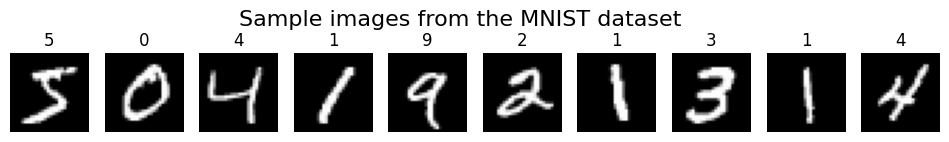

In [2]:
# Load and visualize MNIST
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
plot_mnist(mnist)

# Prepare MNIST data
X, y = mnist["data"], mnist["target"].astype(int)

<br><br>
# **Visualization with Dimensionality Reduction**

Many real-world datasets, like images, have hundreds or thousands of features, making them impossible to visualize directly. **Dimensionality reduction** techniques help us project such high-dimensional data into 2 or 3 dimensions, allowing us to visualize and better understand the structure and patterns within the data.

## Principal Component Analysis (PCA)

**Principal Component Analysis (PCA)** is a fundamental technique for dimensionality reduction. It transforms high-dimensional data into a lower-dimensional space while preserving as much variability (information) as possible.

- **How does it work?**  
  PCA identifies the directions (principal components) where the data varies the most. The first principal component captures the most variance, the second is orthogonal to the first and captures the next highest variance, and so on.
- **Why use it?**  
  By projecting high-dimensional data onto the first few principal components, we can visualize complex datasets and uncover their underlying structure.

In this step, we'll project the 784-dimensional MNIST images onto the first two principal components and visualize the result. It's possible to adjust the number of sampes used (`n_samples`) to speed up the process.

In [3]:
# Subset MNIST data for faster processing
n_samples = 70000
X_subset = X[:n_samples]
y_pca = y[:n_samples].astype(int)

We use `sklearn.decomposition.PCA` to perform PCA and `matplotlib.pyplot` for visualization. The implementation is straightforward, first we define the PCA model and how many components we want to keep.

In [4]:
pca = PCA(n_components=2, random_state=42)


Next we fit the model to the data and transform it to the lower-dimensional space.

In [5]:
X_pca = pca.fit_transform(X_subset)

Finally, we plot the results using the custom function `plot_projection`, which takes care of the visualization.

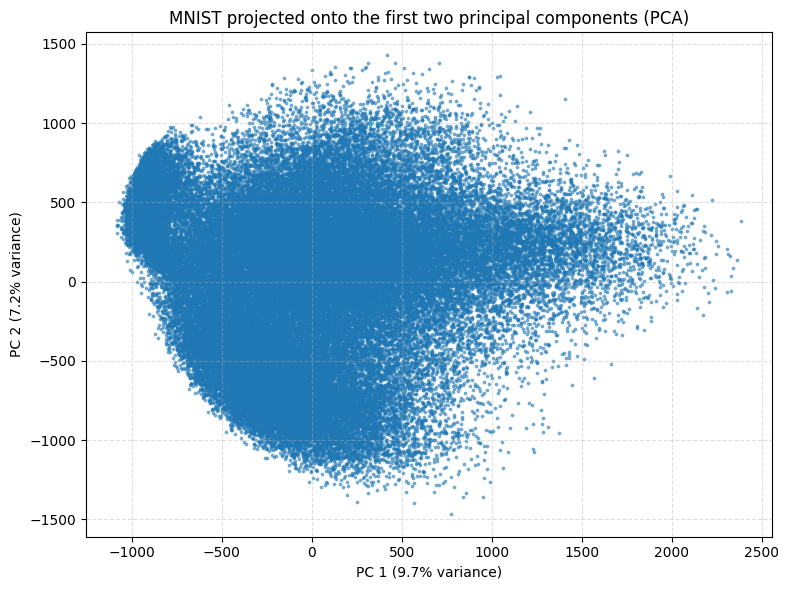

In [6]:
plot_projection(
    X_pca, None,
    title="MNIST projected onto the first two principal components (PCA)",
    xlabel=f"PC 1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)",
    ylabel=f"PC 2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)"
)

The scatter plot above displays each MNIST image as a point, projected onto the first two principal components.  
- **PC 1 and PC 2** represent the directions of greatest variance in the dataset.
- The **explained variance percentages** in the axis labels indicate how much of the dataset’s total variability is captured by each component. In this case *PC1* explains 9.7% of the variance in the data and *PC2* explains 7.2%.

At this stage, we’re not using any color to represent the digit labels.  
In the next step, we’ll color the points to explore how different digits are distributed in this reduced space.

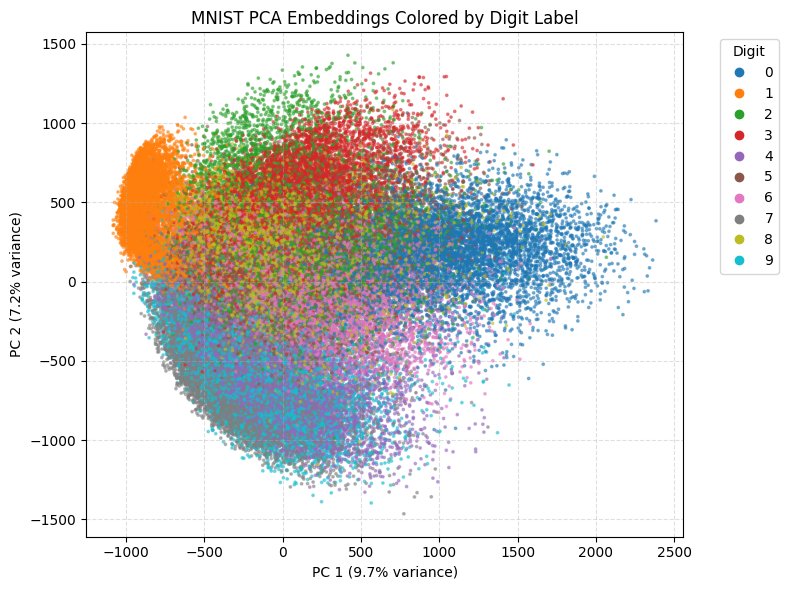

In [7]:
plot_projection(
    X_pca, y_pca,
    title="MNIST PCA Embeddings Colored by Digit Label",
    dataset_name="mnist",
    xlabel=f"PC 1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)",
    ylabel=f"PC 2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)"
)

As we can see in the plot above, images of the digit **1** tend to cluster closely together, indicating that their representations are quite consistent in the PCA-reduced space. In contrast, images of the other digits are more spread out and often overlap with each other.

## Multidimensional Scaling (MDS)

**Multidimensional Scaling (MDS)** is another dimensionality reduction technique.  
Instead of focusing on variance (like PCA), MDS aims to preserve the pairwise distances between samples when projecting high-dimensional data into a lower-dimensional space. This can reveal different structures and relationships within the dataset. Now using a subset is more important as MDS is computationally more expensive than PCA.

In [8]:
# MDS can be slow on large datasets. For demonstration, we'll use a subset.
n_samples = 1000  # You can increase if your machine allows
X_subset = X[:n_samples]
y_mds = y[:n_samples].astype(int)

Let's define the MDS model and how many components we want to keep. Then also transform the data to the lower-dimensional space.

In [9]:
# Fit and transform with MDS
mds = MDS(n_components=2, random_state=42)
X_mds = mds.fit_transform(X_subset)

Plot the results using the custom function `plot_projection`, which takes care of the visualization.

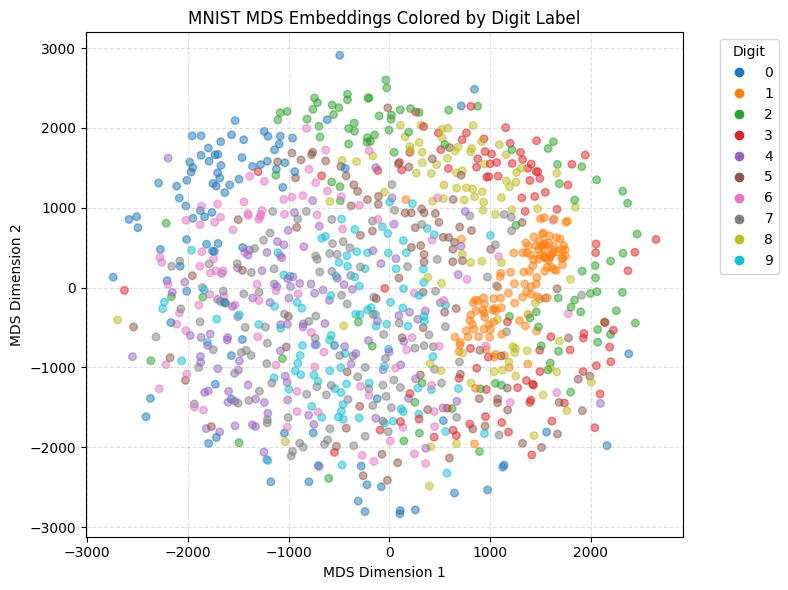

In [10]:
plot_projection(
    X_mds, y_mds,
    title="MNIST MDS Embeddings Colored by Digit Label",
    dataset_name="mnist",
    xlabel="MDS Dimension 1",
    ylabel="MDS Dimension 2"
)

## t-Distributed Stochastic Neighbor Embedding (t-SNE)

**t-SNE** is a popular nonlinear dimensionality reduction algorithm, especially useful for visualizing high-dimensional data.  
Unlike PCA or MDS, t-SNE is designed to preserve local structure, meaning that similar points in high-dimensional space stay close together in the lower-dimensional map. This often results in clearer clusters for data like images or text.

In [11]:
# t-SNE is computationally intensive; use a manageable subset
n_samples = 10000  # Adjust as needed for speed
X_subset = X[:n_samples]
y_tsne = y[:n_samples].astype(int)

Let's define the t-sne model and how many components we want to keep. Then also transform the data to the lower-dimensional space.

In [12]:
# Fit and transform with t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_subset)

Plot the results using the custom function `plot_projection`, which takes care of the visualization.

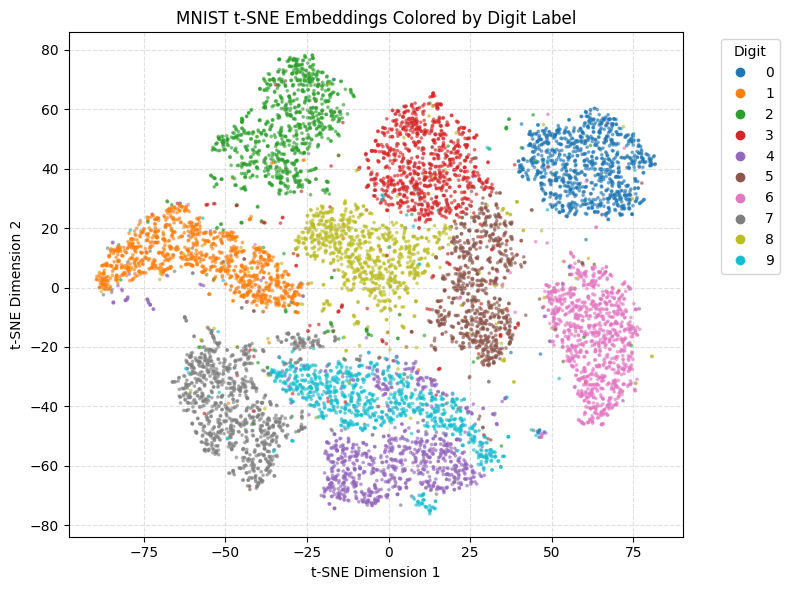

In [13]:
plot_projection(
    X_tsne, y_tsne,
    title="MNIST t-SNE Embeddings Colored by Digit Label",
    dataset_name="mnist",
    xlabel="t-SNE Dimension 1",
    ylabel="t-SNE Dimension 2"
)

## Uniform Manifold Approximation and Projection (UMAP)

**UMAP** is a powerful nonlinear dimensionality reduction technique, similar to t-SNE but often faster and better at preserving both local and global data structure.  
UMAP is widely used for visualizing high-dimensional datasets, revealing clusters and patterns that might not be visible with linear methods like PCA.

In [14]:
# UMAP is efficient but we'll still use a subset for consistency
n_samples = 70000
X_subset = X[:n_samples]
y_umap = y[:n_samples].astype(int)

Let's define the UMAP model and how many components we want to keep. Then also transform the data to the lower-dimensional space.

In [15]:
# Fit and transform with UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X_subset)

Plot the results using the custom function `plot_projection`, which takes care of the visualization.

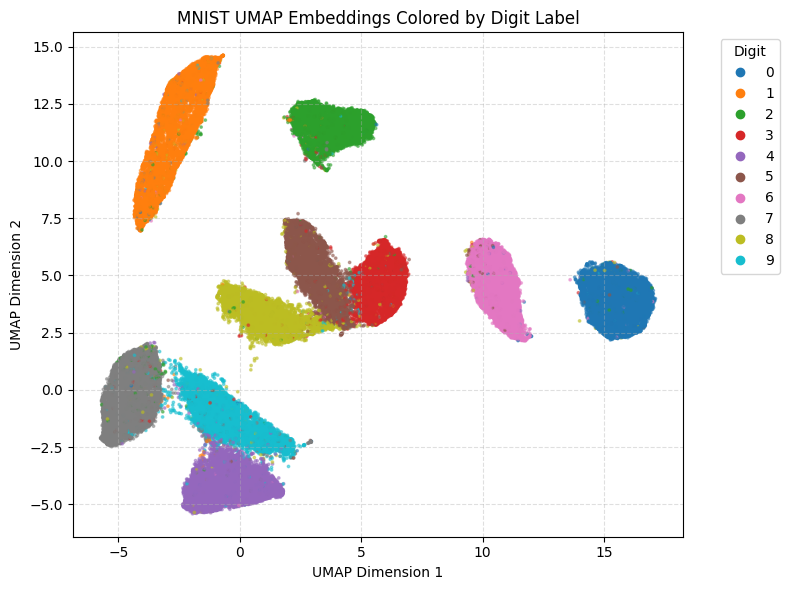

In [16]:
plot_projection(
    X_umap, y_umap,
    title="MNIST UMAP Embeddings Colored by Digit Label",
    dataset_name="mnist",
    xlabel="UMAP Dimension 1",
    ylabel="UMAP Dimension 2"
)

## Dimensionality Reduction Overview

Here is a brief summary of the four dimensionality reduction techniques we explored:

- **PCA (Principal Component Analysis)**
  - Linear technique projecting data onto directions of greatest variance
  - Fast and interpretable, but limited to linear relationships

- **MDS (Multidimensional Scaling)**  
  - Preserves pairwise distances between samples in lower-dimensional space
  - Useful for visualizing similarity relationships

- **t-SNE (t-Distributed Stochastic Neighbor Embedding)**
  - **Advantage**: Preserves nonlinear neighborhood structures and reveals clusters clearly
  - **Limitations**: 
    - Dependent on random seed → different initializations can yield different results
    - Only short distances within clusters (local neighborhoods) are interpretable
    - Distances between clusters are not meaningful

- **UMAP (Uniform Manifold Approximation and Projection)**
  - **Advantages**: 
    - Not dependent on random seed → consistent results across runs
    - Both short distances (within clusters) and long distances (between clusters) are interpretable
    - Fast and scales well to large datasets
  - **Characteristic**: Often produces plots with empty space between well-separated clusters

**Disadvantages of PCA and MDS:**
- Both assume data can be well-represented by a linear subspace (e.g., a flat plane for 2D plotting)
- However, there's rarely a good reason why real-world data should lie in a linear plane
- Cannot capture complex, nonlinear neighborhood structures

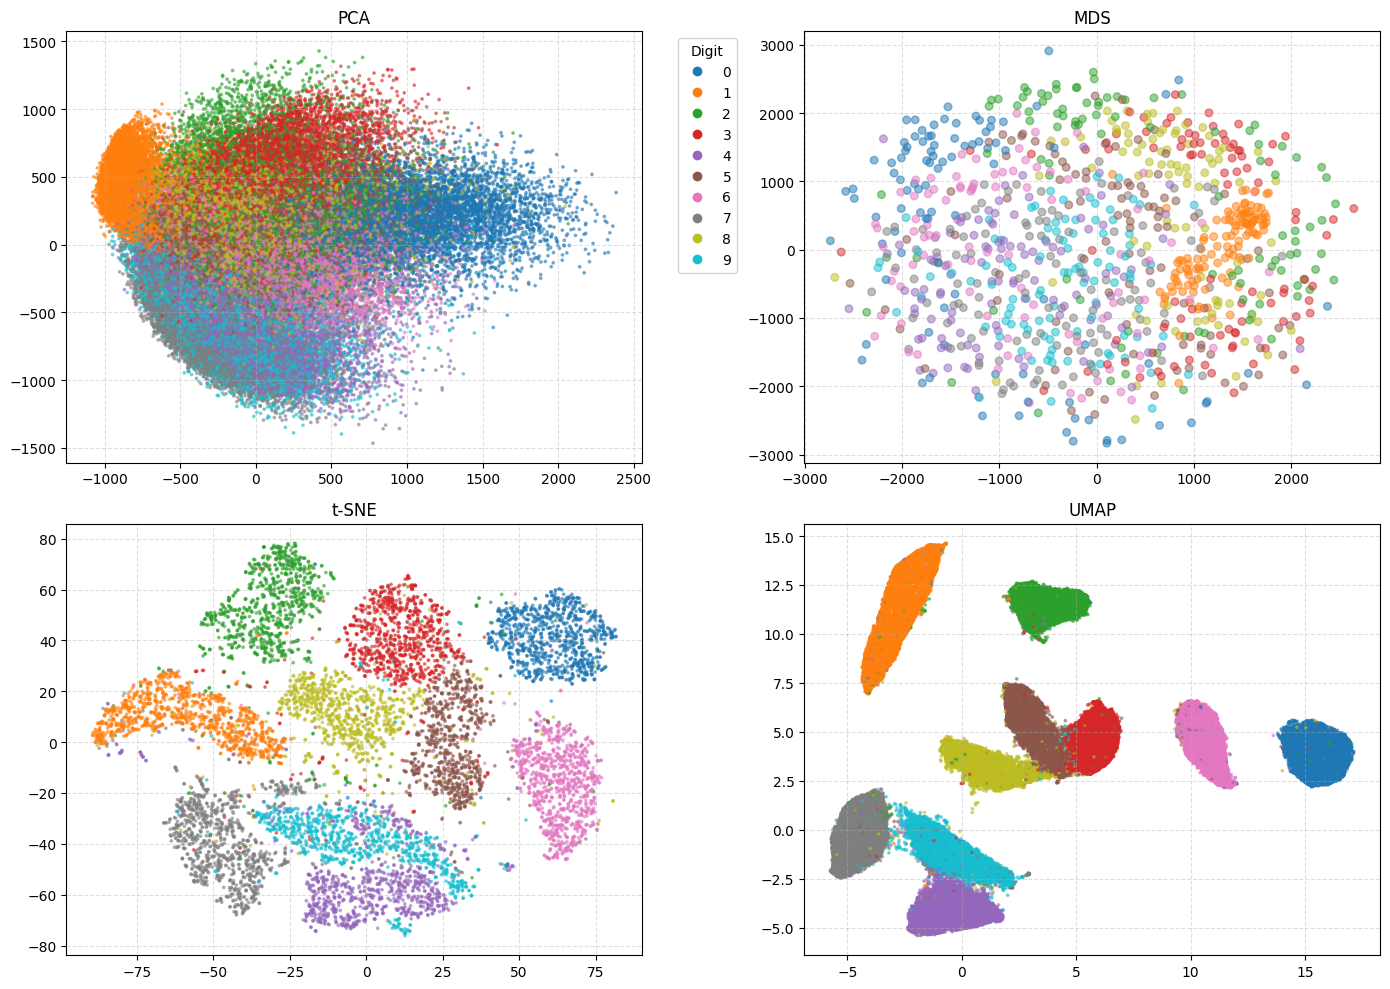

In [17]:
# Each embedding and label set
embeddings = [
    (X_pca, y_pca, "PCA"),
    (X_mds, y_mds, "MDS"),
    (X_tsne, y_tsne, "t-SNE"),
    (X_umap, y_umap, "UMAP"),
]

plot_projection_grid(embeddings)

---
<br><br>
# **Visualizing High-Dimensional Medical Datasets**

So far, we've explored how dimensionality reduction techniques can uncover patterns and structure in benchmark datasets like MNIST.  
Now, let's take the next step and apply these powerful tools to real clinical data.

In this section, we'll use the **Breast Cancer Wisconsin dataset** as a practical example. We'll see how techniques like PCA, t-SNE, and UMAP can project patient data into two dimensions, making hidden patterns and diagnostic groups visible—even in complex, high-dimensional medical spaces.

## Introduction to the Breast Cancer Wisconsin Dataset

The **Breast Cancer Wisconsin (Diagnostic) dataset** is a widely used benchmark in the biomedical machine learning community. It contains features computed from digitized images of breast mass tissue, which help clinicians and researchers distinguish between benign and malignant tumors.

- **Samples:** 569 breast mass cases
- **Features:** 30 numeric features, computed from a digitized image of a fine needle aspirate (FNA) of a breast mass  
  (e.g., radius, texture, perimeter, area, smoothness, etc.)
- **Labels:** 
    - `0` = malignant (cancerous)
    - `1` = benign (non-cancerous)
- **Data type:** All features are continuous, numeric (floating-point)
- **No missing values:** The dataset is complete and ready for analysis
- **Normalization:** We normalize the dataset for clarity, here we use sklearn's `StandardScaler`

Its clarity, moderate size, and clinical importance make it ideal for visualizing and understanding algorithms like PCA, MDS, t-SNE, and UMAP in a real-world biomedical setting.

In [18]:
# Load dataset
data = load_breast_cancer()

X, y = data['data'], data['target']
feature_names = data['feature_names']
outcome_names = data['target_names']

# Convert to DataFrame for convenience
df = pd.DataFrame(X, columns=feature_names)
df['outcome'] = y

# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [19]:
df.head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                 0.07871  ...          17.33           184.60      2019.0   
1                 0.05667  ...          23.41           158.80      1956.0   
2                 0.05999  ...          25.53           152.50      1709.0   
3                 0.09744  ...          26.50            98.87       567.7   
4                 0.05883  ...          16.67           152.20      1575.0   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   
2            0.1444             0.4245           0.4504                0.2430   
3            0.2098             0.8663           0.6869                0.2575   
4            0.1374             0.2050           0.4000                0.1625   

   worst symmetry  worst fractal dimension  outcome  
0          0.4601                  0.11890        0  
1          0.2750                  0.08902        0  
2          0.3613                  0.08758        0  
3          0.6638                  0.17300        0  
4          0.2364                  0.07678        0  

[5 rows x 31 columns]

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [21]:
df.describe()

mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%           0.086370          0.064920        0.029560             0.020310   
50%           0.095870          0.092630        0.061540             0.033500   
75%           0.105300          0.130400        0.130700             0.074000   
max           0.163400          0.345400        0.426800             0.201200   

       mean symmetry  mean fractal dimension  ...  worst texture  \
count     569.000000              569.000000  ...     569.000000   
mean        0.181162                0.062798  ...      25.677223   
std         0.027414                0.007060  ...       6.146258   
min         0.106000                0.049960  ...      12.020000   
25%         0.161900                0.057700  ...      21.080000   
50%         0.179200                0.061540  ...      25.410000   
75%         0.195700                0.066120  ...      29.720000   
max         0.304000                0.097440  ...      49.540000   

       worst perimeter   worst area  worst smoothness  worst compactness  \
count       569.000000   569.000000        569.000000         569.000000   
mean        107.261213   880.583128          0.132369           0.254265   
std          33.602542   569.356993          0.022832           0.157336   
min          50.410000   185.200000          0.071170           0.027290   
25%          84.110000   515.300000          0.116600           0.147200   
50%          97.660000   686.500000          0.131300           0.211900   
75%         125.400000  1084.000000          0.146000           0.339100   
max         251.200000  4254.000000          0.222600           1.058000   

       worst concavity  worst concave points  worst symmetry  \
count       569.000000            569.000000      569.000000   
mean          0.272188              0.114606        0.290076   
std           0.208624              0.065732        0.061867   
min           0.000000              0.000000        0.156500   
25%           0.114500              0.064930        0.250400   
50%           0.226700              0.099930        0.282200   
75%           0.382900              0.161400        0.317900   
max           1.252000              0.291000        0.663800   

       worst fractal dimension     outcome  
count               569.000000  569.000000  
mean                  0.083946    0.627417  
std                   0.018061    0.483918  
min                   0.055040    0.000000  
25%                   0.071460    0.000000  
50%                   0.080040    1.000000  
75%                   0.092080    1.000000  
max                   0.207500    1.000000  

[8 rows x 31 columns]

In [22]:
# Missing values check
print("\nMissing Values:")
df.isnull().sum()


Missing Values:


mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
outcome                    0
dtype: int64

To visualize the dataset, let's visualize some features distributions.

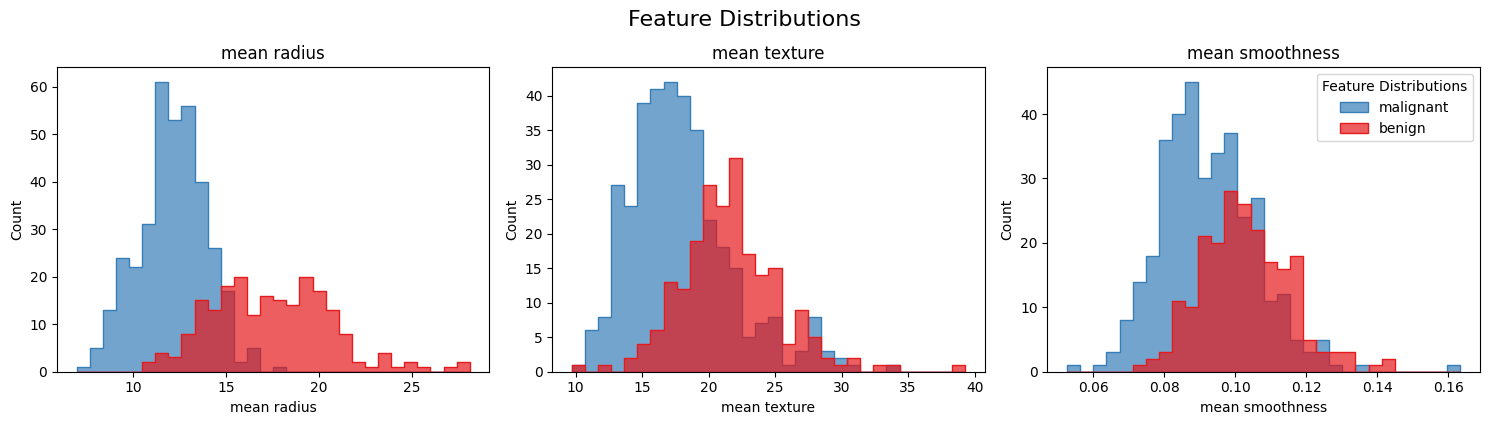

In [23]:
features = ['mean radius', 'mean texture', 'mean smoothness']
visualize_features(df, features, 'outcome', outcome_names)

## Principle Component Analysis (PCA)

In [24]:
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)


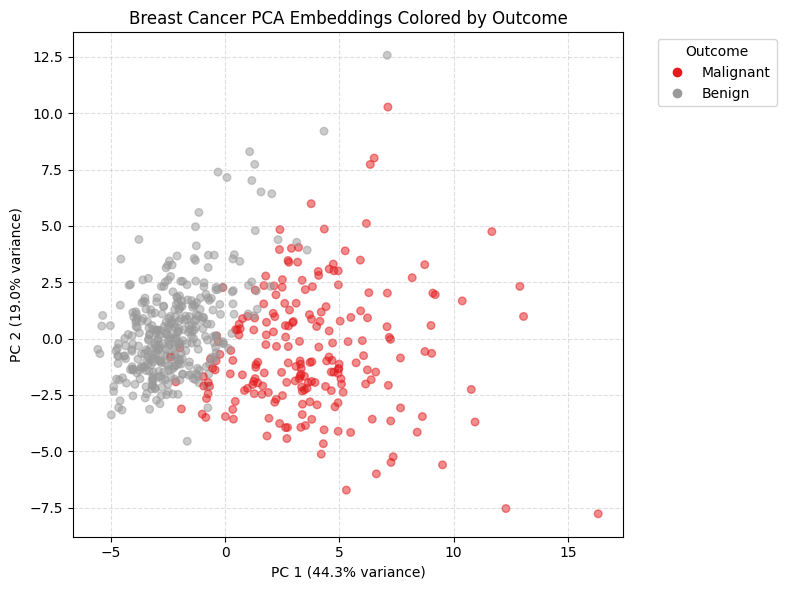

In [25]:
plot_projection(
    X_pca, y,
    title="Breast Cancer PCA Embeddings Colored by Outcome",
    xlabel=f"PC 1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)",
    ylabel=f"PC 2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)",
    dataset_name="breast_cancer"
)

**PCA Results on Breast Cancer Dataset**
- Groups are not completely separable, showing the limitations of linear dimensionality reduction
- Benign cases (blue) tend to cluster together on the left side of the plot
- Main sources of variation do capture some diagnostic information

## Multidimensional Scaling (MDS)

In [26]:
# Fit MDS
mds = MDS(n_components=2, random_state=42)
X_mds = mds.fit_transform(X)

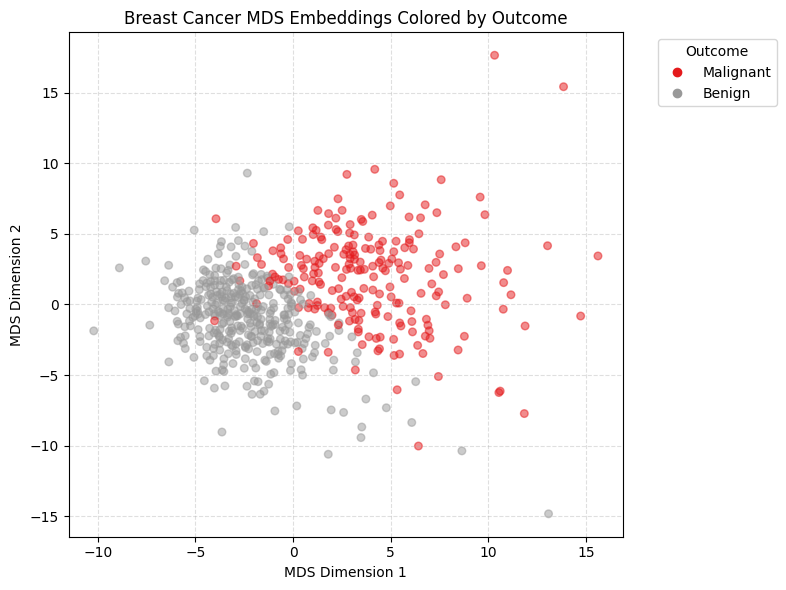

In [27]:
plot_projection(
    X_mds, y,
    title="Breast Cancer MDS Embeddings Colored by Outcome",
    xlabel="MDS Dimension 1",
    ylabel="MDS Dimension 2",
    dataset_name="breast_cancer"
)

**MDS Results on Breast Cancer Dataset**
- Similar to PCA, groups are not distinctly separated, confirming linear method limitations
- Benign cases (blue) cluster together on the right side of the plot
- Malignant cases are more dispersed with greater overlap than in PCA

## t-SNE

In [28]:
# Fit t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

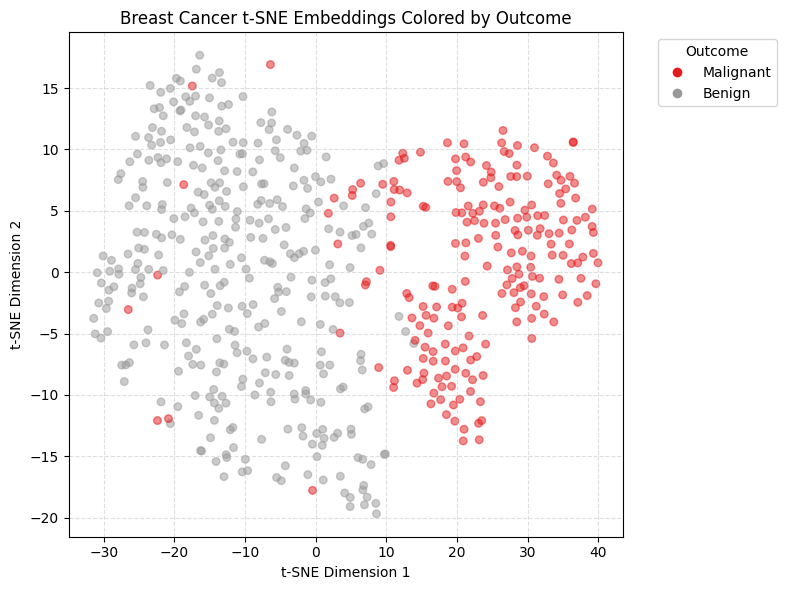

In [29]:
plot_projection(
    X_tsne, y,
    title="Breast Cancer t-SNE Embeddings Colored by Outcome",
    xlabel="t-SNE Dimension 1",
    ylabel="t-SNE Dimension 2",
    dataset_name="breast_cancer"
)

**t-SNE Results on Breast Cancer Dataset**
- Separation into two main groups along t-SNE 1 dimension (around x = 10)
- Most benign cases (blue) cluster on the left, malignant cases (red) on the right
- Minimal overlap with only a few malignant cases appearing in the benign cluster

## UMAP

In [30]:
# Fit UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X)

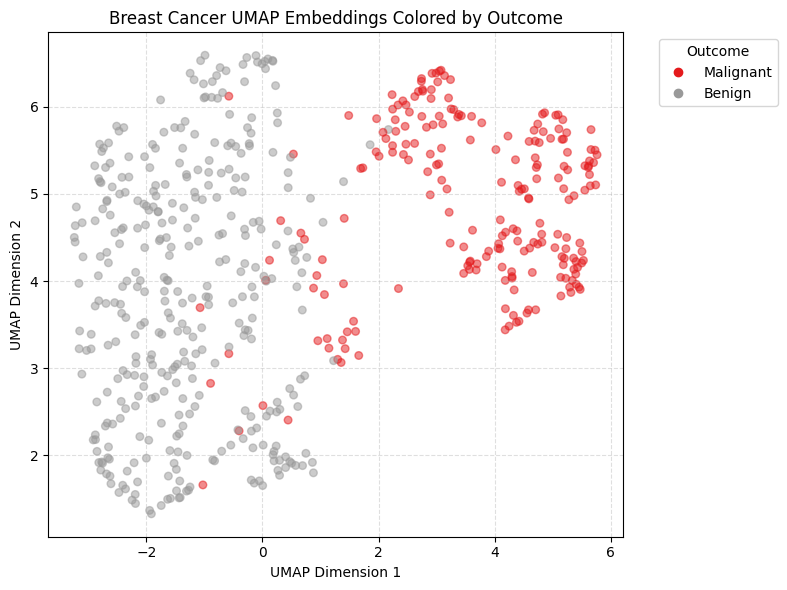

In [31]:
plot_projection(
    X_umap, y,
    title="Breast Cancer UMAP Embeddings Colored by Outcome",
    xlabel="UMAP Dimension 1",
    ylabel="UMAP Dimension 2",
    dataset_name="breast_cancer"
)

**UMAP Results on Breast Cancer Dataset**
- Even clearer separation into two distinct groups compared to t-SNE
- Benign cases (blue) form a cluster on the left, malignant cases (red) on the right
- Minimal overlap with only a small mixing region between clusters

## Overview 

- **Value of Dimensionality Reduction in Medicine**
  - Uncovers hidden patterns, clusters, and relationships in high-dimensional medical data
  - Supports clinical insight and guides further analysis or decision-making

- **Method Performance Comparison**
  - **Linear methods (PCA, MDS)**: Limited separation due to linear assumptions
  - **Nonlinear methods (t-SNE, UMAP)**: Superior class separation by preserving neighborhood structures

- **Important Limitations**
  - All visualizations are simplifications of complex high-dimensional information
  - Projecting to 2D may obscure important details and relationships
  - Apparent clusters may not always reflect true biological differences

- **Best Practices**
  - Always validate findings with domain knowledge and additional analysis
  - Consider multiple dimensionality reduction techniques for comprehensive understanding
  - Remember that visualization is an exploratory tool, not definitive evidence

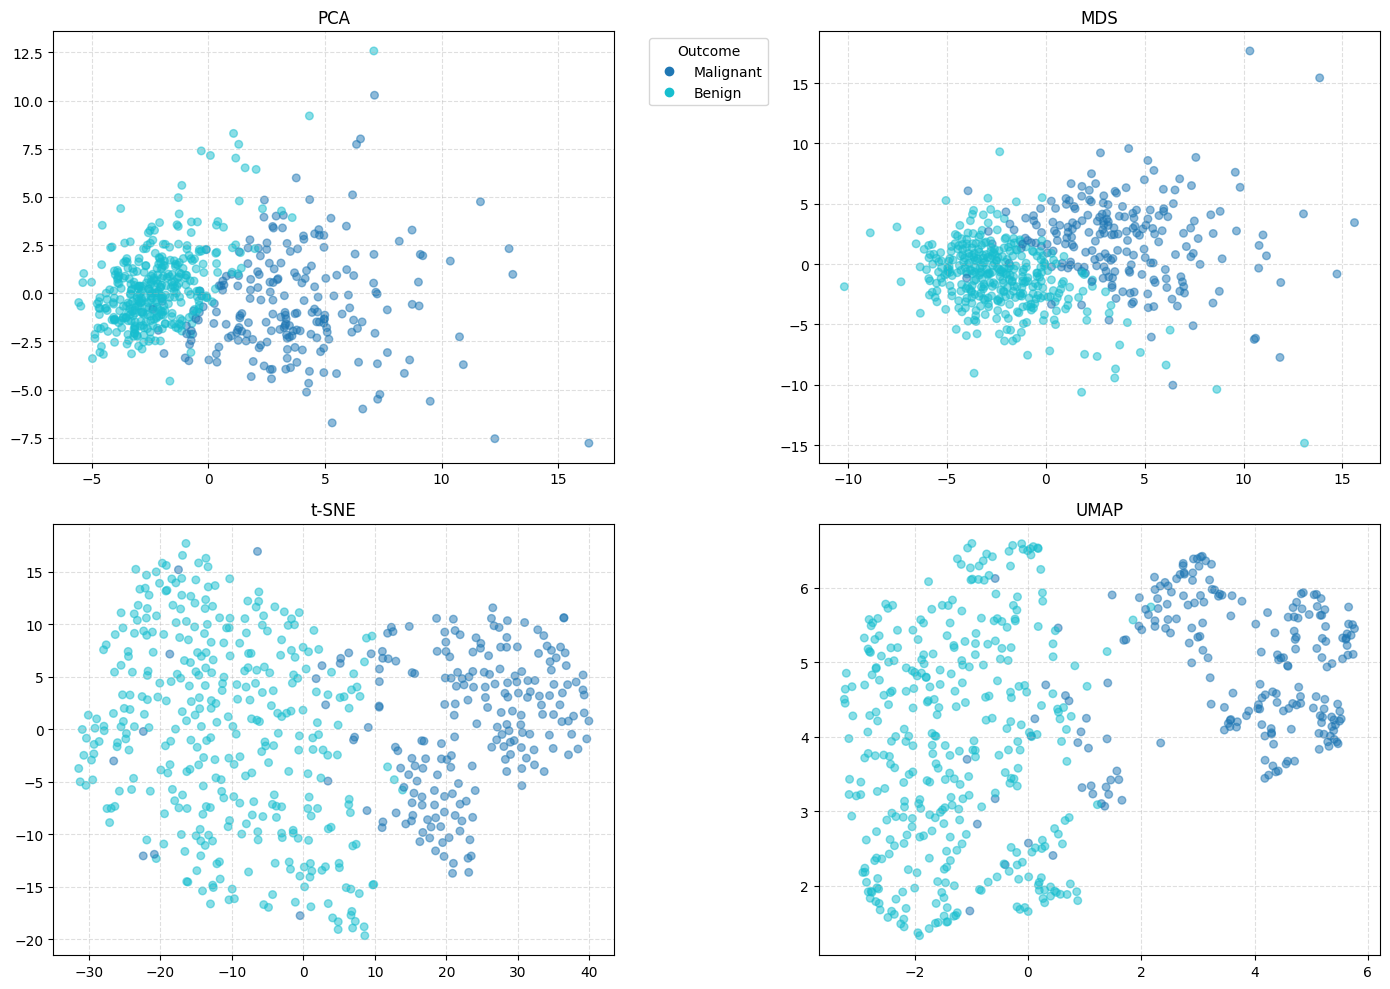

In [32]:
# Each embedding and label set
embeddings = [
    (X_pca, y, "PCA"),
    (X_mds, y, "MDS"),
    (X_tsne, y, "t-SNE"),
    (X_umap, y, "UMAP"),
]

plot_projection_grid(embeddings, dataset_name="breast_cancer")

---
<br><br>
# **Similarity Measures**

The dimensionality reduction techniques we explored—PCA, MDS, t-SNE, and UMAP—all rely on one fundamental concept: **measuring how similar or different data points are to each other**. While these visualizations allowed us to see patterns and clusters, we've been judging similarity only through visual inspection.

To move beyond visual interpretation, we need precise mathematical tools to quantify similarity and distance between patients or data points.

This section explores various distance and similarity metrics, providing the foundation underlying dimensionality reduction and many other machine learning applications.

## Similarity Metrics for Continuous Data

When working with patient measurements or medical test results, it’s often important to compare how similar or different two cases are. **Similarity metrics** (or *distance measures*) provide a mathematical way to quantify how close two data points are in a dataset with continuous values.

Two of the most common metrics are:

- **Euclidean distance:** Measures the straight-line distance between two points, much like using a ruler. It’s intuitive—cases are “closer” if their values across all features are more similar.
- **Manhattan distance:** Also called “city block” distance, this adds up the absolute differences across all features, similar to navigating a city grid. It is less sensitive to large differences in any single measurement.

Before we use these metrics on a medical dataset, let's make a simple example to illustrate these metrics.

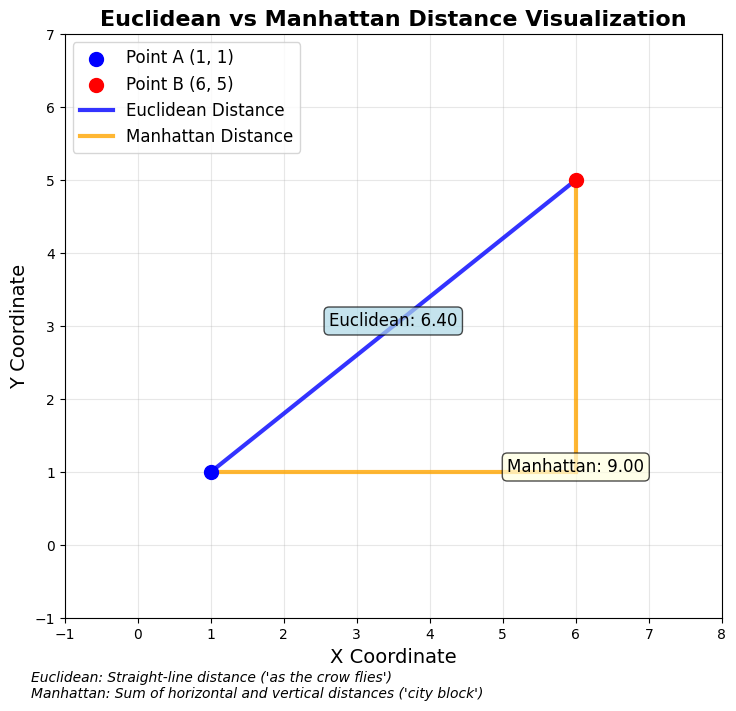

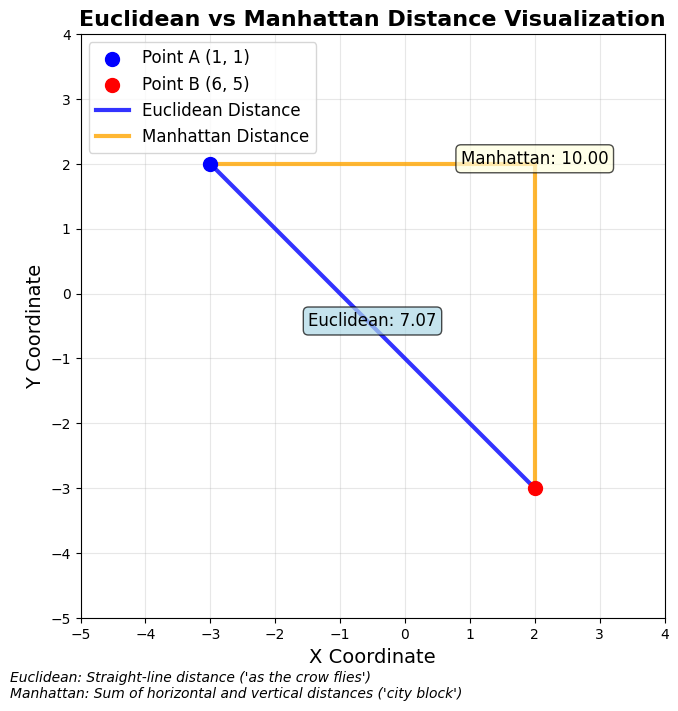

In [33]:
# Call the function to plot the distance comparison
plot_distance_comparison(np.array([1, 1]), np.array([6, 5]))
plot_distance_comparison(np.array([-3, 2]), np.array([2, -3]))

In the following examples, we’ll use the Breast Cancer Wisconsin dataset to illustrate how these metrics work in practice and how they help us understand the similarity between patient profiles. First let's show how to calculate the similarity metrics for two patients.

In [34]:
# Compute the full distance matrices
euclidean_dist = pairwise_distances(X, metric='euclidean')
manhattan_dist = pairwise_distances(X, metric='manhattan')

print("\nEuclidean Distance Matrix:"
      "\n", euclidean_dist[:5, :5])  # Displaying only the first 5x5 submatrix


Euclidean Distance Matrix:
 [[ 0.         10.31849715  6.77763352 10.47267382  8.67103637]
 [10.31849715  0.          5.0320153  16.25073886  4.37888839]
 [ 6.77763352  5.0320153   0.         12.84472056  4.46222854]
 [10.47267382 16.25073886 12.84472056  0.         15.37530011]
 [ 8.67103637  4.37888839  4.46222854 15.37530011  0.        ]]


However as this is not very intuitive, we will visualize the similarity matrix for the entire dataset. This allows us to see how similar each patient is to every other patient in the dataset. We provide the function `plot_similarity_matrices` to visualize the similarity matrix.

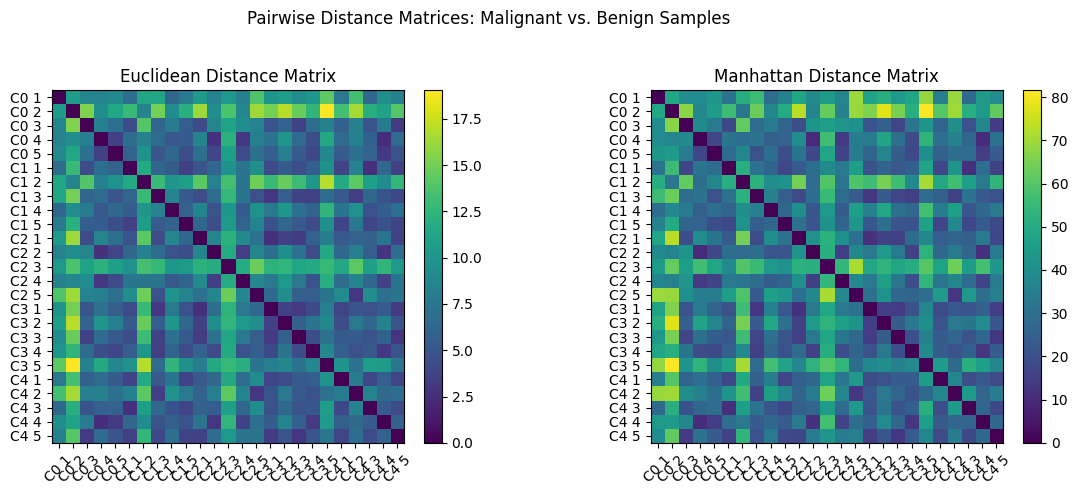

In [45]:
plot_similarity_matrices([euclidean_dist, manhattan_dist],
                         y,
                         titles=["Euclidean Distance Matrix", "Manhattan Distance Matrix"],
                         suptitle="Pairwise Distance Matrices: Malignant vs. Benign Samples")

### Visualizing Similarity Matrices

A **similarity matrix** (or, more precisely in this case, a *distance matrix*) provides a summary of how close or far apart each pair of samples is in our dataset. Each cell in the matrix shows the distance between two samples: smaller values (darger colors) mean the samples are more similar, while larger values (bright colors) indicate greater differences. By visualizing these matrices as heatmaps, we can quickly spot patterns or clusters among the samples.

However, as datasets grow larger and more complex, these matrices become difficult to interpret directly. To better understand the relationships represented by these distances, we can use dimensionality reduction techniques like **PCA** and **t-SNE**. These methods allow us to project the complex patterns in the distance matrix into two dimensions, making it easier to identify clusters and trends visually.

In [39]:
# PCA on distance matrices
pca = PCA(n_components=2)
X_pca_euclidean = pca.fit_transform(euclidean_dist)
X_pca_manhattan = pca.fit_transform(manhattan_dist)

# t-SNE on distance matrices
tsne = TSNE(n_components=2, random_state=42)
X_tsne_euclidean = tsne.fit_transform(euclidean_dist)
X_tsne_manhattan = tsne.fit_transform(manhattan_dist)

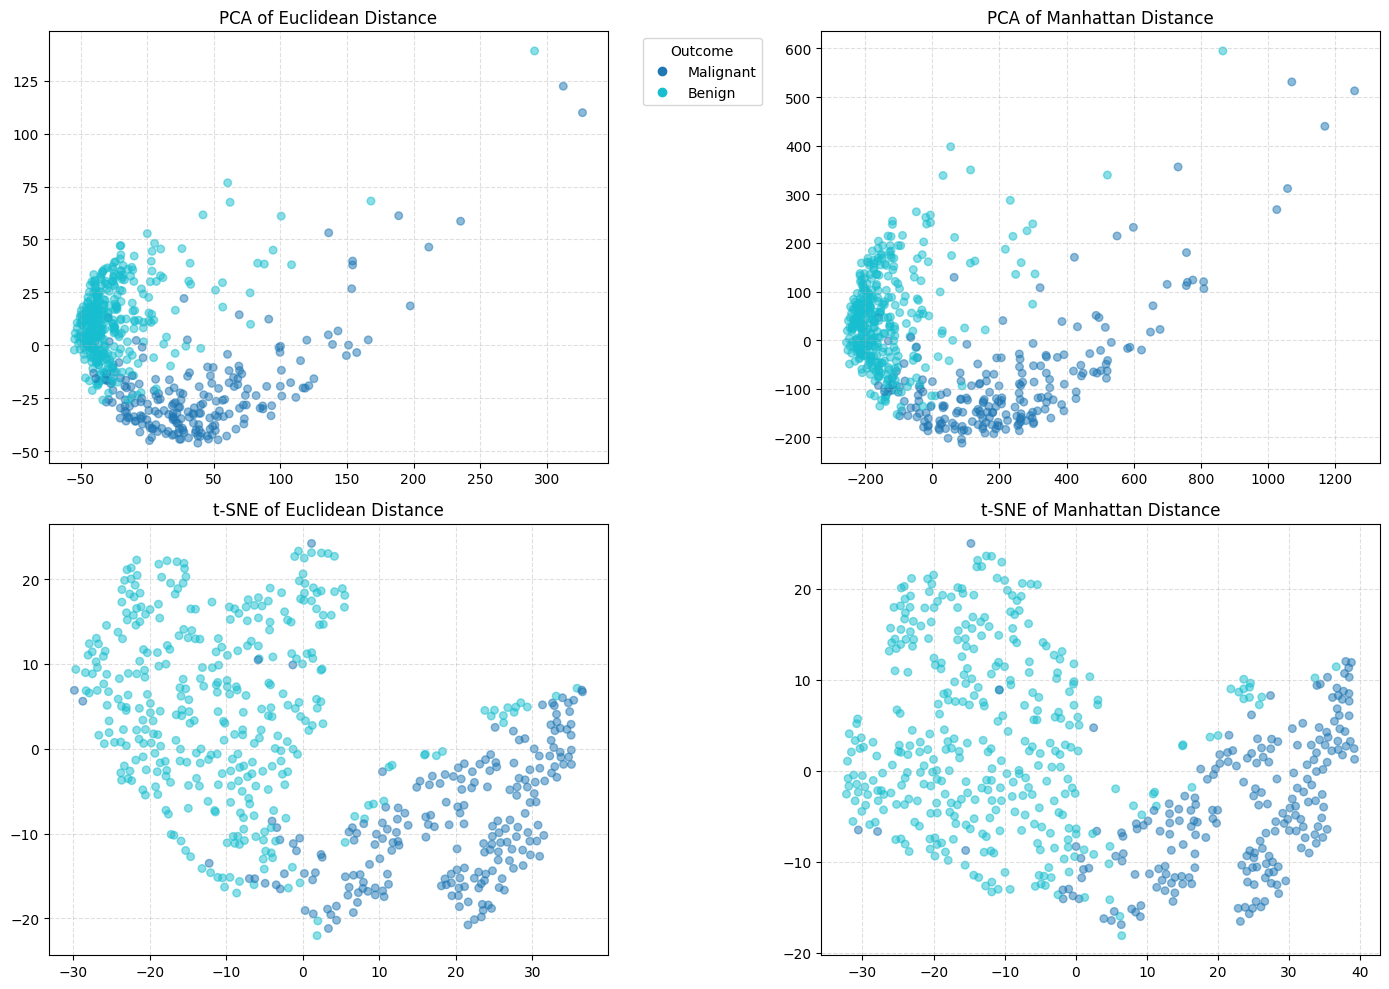

In [40]:
# Plotting
embeddings = [
    (X_pca_euclidean, y, "PCA of Euclidean Distance"),
    (X_pca_manhattan, y, "PCA of Manhattan Distance"),
    (X_tsne_euclidean, y, "t-SNE of Euclidean Distance"),
    (X_tsne_manhattan, y, "t-SNE of Manhattan Distance"),
]

plot_projection_grid(embeddings, dataset_name="breast_cancer")

## Similarity Metrics for Categorical Data

When analyzing patient records or clinical survey results, data often comes in the form of categories—such as “yes/no” answers, types of symptoms, or classifications. **Similarity metrics** for categorical data provide a mathematical way to compare how alike two cases are, even when values are not numeric.

In the following examples, we’ll use the Stroke Prediction dataset to illustrate how these metrics can help us understand similarities between patient profiles based on categorical and binary clinical features.

### Introduction to the Heart Disease Dataset

The **Heart Disease Dataset** is a widely-used clinical dataset from the UCI Machine Learning Repository that focuses on predicting the presence of heart disease based on various cardiovascular risk factors and diagnostic measurements. Originally collected from four medical institutions, this dataset has become a benchmark for medical machine learning applications.

- **Samples:** 303 patient records (after removing missing values)
- **Features:** 13 variables including both categorical (e.g., sex, chest pain type, exercise-induced angina) and numerical (e.g., age, blood pressure, cholesterol level, maximum heart rate) data
- **Label:** 
    - `0` = no heart disease
    - `1` = presence of heart disease (originally 1-4 severity levels, converted to binary)
- **Data type:** A mix of categorical and numerical features
- **Missing values:** Some missing values in `ca` (number of major vessels) and `thal` (thalassemia type)
- [Link for more information](https://archive.ics.uci.edu/dataset/45/heart+disease)

In [46]:
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 

# Combine features and targets for easier processing
df = pd.concat([X, y], axis=1)

# Handle missing values
df = df.dropna()

# Convert target to binary (0 = no heart disease, 1+ = heart disease)
df['num'] = (df['num'] > 0).astype(int) 

In [47]:
df.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

    ca  thal  num  
0  0.0   6.0    0  
1  3.0   3.0    1  
2  2.0   7.0    1  
3  0.0   3.0    0  
4  0.0   3.0    0

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    int64  
 1   sex       297 non-null    int64  
 2   cp        297 non-null    int64  
 3   trestbps  297 non-null    int64  
 4   chol      297 non-null    int64  
 5   fbs       297 non-null    int64  
 6   restecg   297 non-null    int64  
 7   thalach   297 non-null    int64  
 8   exang     297 non-null    int64  
 9   oldpeak   297 non-null    float64
 10  slope     297 non-null    int64  
 11  ca        297 non-null    float64
 12  thal      297 non-null    float64
 13  num       297 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 34.8 KB


In [49]:
df.describe()

age         sex          cp    trestbps        chol         fbs  \
count  297.000000  297.000000  297.000000  297.000000  297.000000  297.000000   
mean    54.542088    0.676768    3.158249  131.693603  247.350168    0.144781   
std      9.049736    0.468500    0.964859   17.762806   51.997583    0.352474   
min     29.000000    0.000000    1.000000   94.000000  126.000000    0.000000   
25%     48.000000    0.000000    3.000000  120.000000  211.000000    0.000000   
50%     56.000000    1.000000    3.000000  130.000000  243.000000    0.000000   
75%     61.000000    1.000000    4.000000  140.000000  276.000000    0.000000   
max     77.000000    1.000000    4.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  297.000000  297.000000  297.000000  297.000000  297.000000  297.000000   
mean     0.996633  149.599327    0.326599    1.055556    1.602694    0.676768   
std      0.994914   22.941562    0.469761    1.166123    0.618187    0.938965   
min      0.000000   71.000000    0.000000    0.000000    1.000000    0.000000   
25%      0.000000  133.000000    0.000000    0.000000    1.000000    0.000000   
50%      1.000000  153.000000    0.000000    0.800000    2.000000    0.000000   
75%      2.000000  166.000000    1.000000    1.600000    2.000000    1.000000   
max      2.000000  202.000000    1.000000    6.200000    3.000000    3.000000   

             thal         num  
count  297.000000  297.000000  
mean     4.730640    0.461279  
std      1.938629    0.499340  
min      3.000000    0.000000  
25%      3.000000    0.000000  
50%      3.000000    0.000000  
75%      7.000000    1.000000  
max      7.000000    1.000000

In [50]:
# Missing values check
print("\nMissing Values:")
df.isnull().sum()


Missing Values:


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

For this section, we focus on the **categorical and binary features** to explore similarity metrics designed for categorical data. Let's clean up our data, such that we don't include numerical data.

In [51]:
# Select categorical/binary features for distance calculations
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
df_cat = df[categorical_features]

# Convert to numeric format
X = df_cat.astype(float).values
y = df['num'].values
outcome_names = ['No Heart Disease', 'Heart Disease']

Having explored the structure and content of the Heart Disease dataset, we’re now ready to examine how different similarity metrics behave when applied to real patient data. By calculating and visualizing the resulting similarity (or distance) matrices, we can gain insights into the patterns, clusters, and relationships among patients based on their categorical risk factors. 

Three commonly used metrics for categorical data are:

- **Simple Matching Coefficient:** This metric counts the proportion of features where two cases share the same category. It treats matches of presence and absence equally.
- **Jaccard Similarity:** This metric focuses only on features where at least one case has a “yes” (or presence), ignoring cases where both are “no.” It’s particularly useful when the presence of a trait is more important than its absence.
- **Hamming Distance:** This measures the total number of positions where two cases differ. In other words, it counts how many features would need to change for the two cases to match exactly.

In [52]:
simple_matching_dist = simple_matching_distance(X)
jaccard_dist = pairwise_distances(X, metric='jaccard')
hamming_dist = pairwise_hamming_distance_similarity(X)

print("\nHamming Distance Matrix:"
      "\n", hamming_dist[:5, :5])  # Displaying only the


Hamming Distance Matrix:
 [[0 6 6 4 5]
 [6 0 2 5 5]
 [6 2 0 6 6]
 [4 5 6 0 4]
 [5 5 6 4 0]]


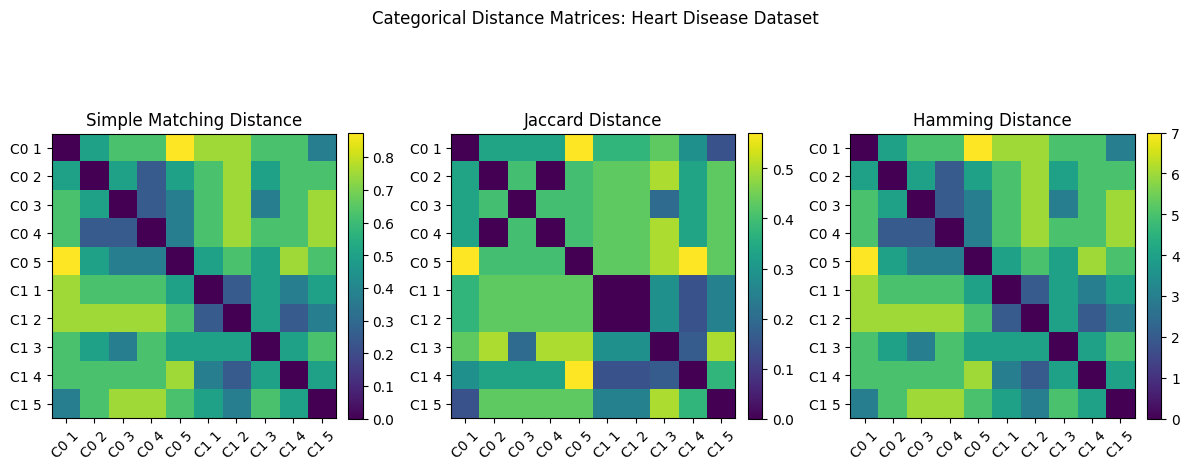

In [53]:
plot_similarity_matrices(
    [simple_matching_dist, jaccard_dist, hamming_dist],
    y,
    titles=["Simple Matching Distance", "Jaccard Distance", "Hamming Distance"],
    suptitle="Categorical Distance Matrices: Heart Disease Dataset"
)

- We calculated similarity matrices using the three different categorical distance metrics and visualized them for the first 5 healthy patients (H1-H5) and first 5 patients with heart disease (D1-D5)
- Notice the darker diagonal blocks in the top-left (H1-H5) and bottom-right (D1-D5) corners, suggesting that patients within the same health status tend to be more similar to each other
- The off-diagonal blocks (top-right and bottom-left) generally show brighter colors, indicating that healthy and diseased patients are more dissimilar from each other

To better understand the relationships and potential clusters in the data, let’s project these distances into two dimensions using **PCA** and **t-SNE**.

In [61]:
# Apply PCA to each distance matrix
pca = PCA(n_components=2, random_state=42)
simple_matching_pca = pca.fit_transform(simple_matching_dist)
jaccard_pca = pca.fit_transform(jaccard_dist)
hamming_pca = pca.fit_transform(hamming_dist)

# Apply t-SNE to each distance matrix
tsne = TSNE(n_components=2, random_state=42)
simple_matching_tsne = tsne.fit_transform(simple_matching_dist)
jaccard_tsne = tsne.fit_transform(jaccard_dist)
hamming_tsne = tsne.fit_transform(hamming_dist)


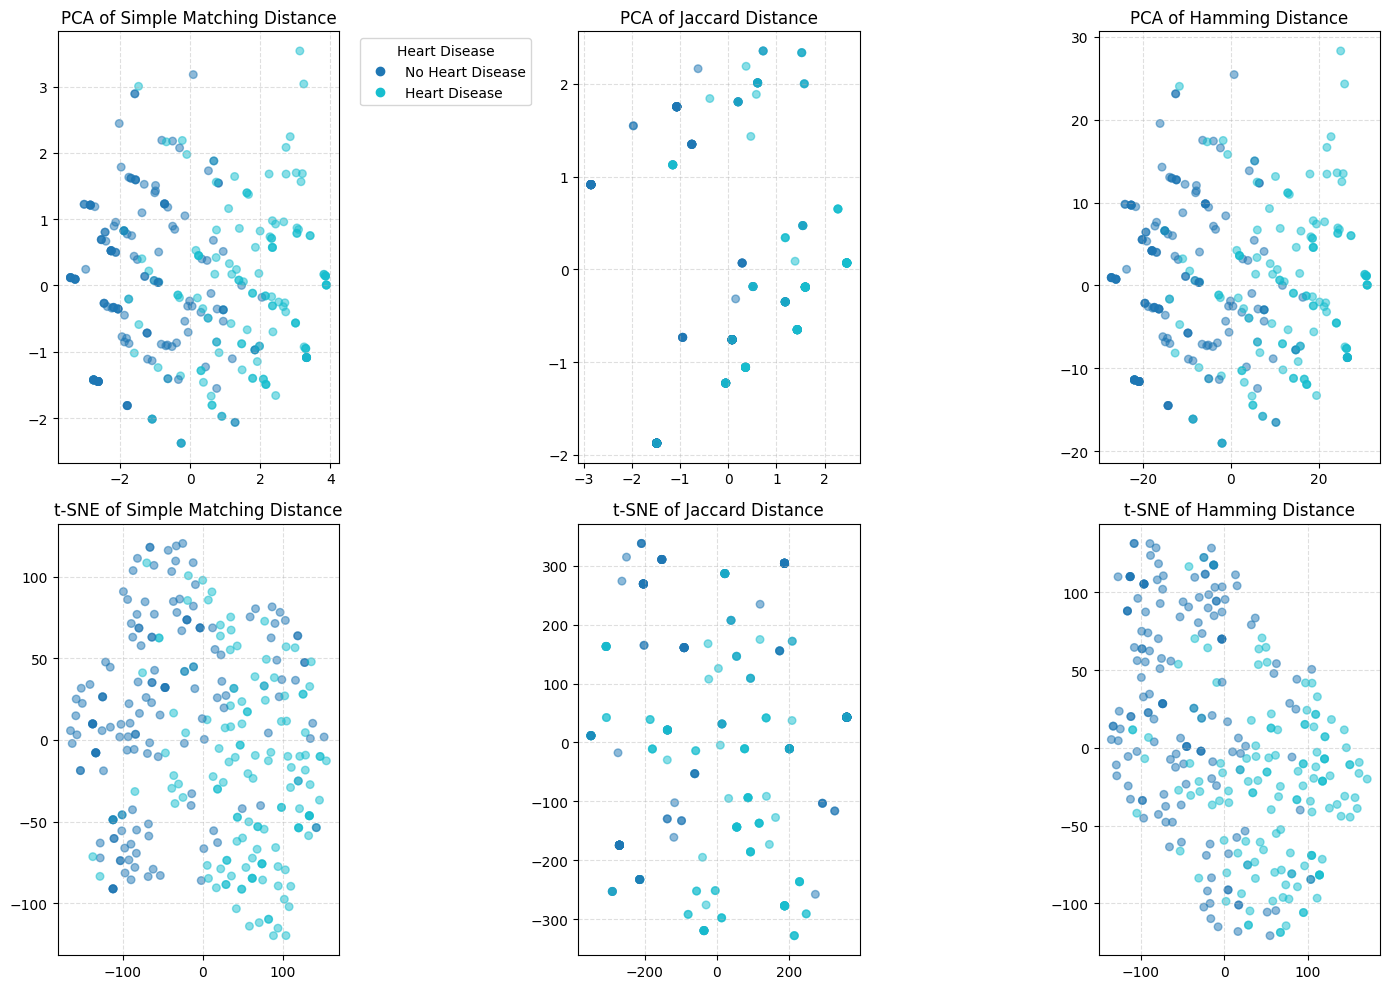

In [62]:
# Plotting
embeddings = [
    (simple_matching_pca, y, "PCA of Simple Matching Distance"),
    (jaccard_pca, y, "PCA of Jaccard Distance"),
    (hamming_pca, y, "PCA of Hamming Distance"),
    (simple_matching_tsne, y, "t-SNE of Simple Matching Distance"),
    (jaccard_tsne, y, "t-SNE of Jaccard Distance"),
    (hamming_tsne, y, "t-SNE of Hamming Distance"),
]

plot_projection_grid(embeddings, dataset_name="heart_disease")

We applied PCA (top row) and t-SNE (bottom row) to the distance matrices computed using three categorical similarity metrics, projecting each patient into a 2D space for visualization

- **PCA Results (Linear Projection):**
  - Shows relatively gradual separation between healthy and diseased patients
  - Hamming and Simple Matching distances show similar clustering patterns
  - Jaccard distance appears to provide the most scattered distribution in PCA space

- **t-SNE Results (Non-linear Projection):**
  - Reveals more distinct clustering patterns compared to PCA
  - Creates clearer visual separation between patient groups
  - Better preserves local neighborhood structures from the original high-dimensional distance space

The clear clustering visible in t-SNE projections suggests that categorical cardiovascular risk factors capture meaningful patterns that distinguish between healthy patients and those with heart disease, with non-linear dimensionality reduction revealing these patterns more effectively than linear methods

## Similarity Metrics for Mixed Data

Healthcare datasets typically contain mixed data types:
- Numerical values (age, blood pressure, cholesterol levels)
- Categorical information (gender, chest pain type, exercise-induced symptoms)

**Gower's dissimilarity** addresses this by:
- Combining numeric and categorical differences into a single similarity measure
- Automatically normalizing continuous variables
- Handling categorical variables appropriately

We'll demonstrate Gower's metric on the Heart Disease dataset using all relevant features to show how it provides a comprehensive view of patient similarity across mixed data types.

In [55]:
# Select features: mix of numerical and categorical for Heart Disease dataset
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

# Combine all features for Gower distance
gower_features = continuous_features + categorical_features
df_gower = df[gower_features]  # include target for later use

# For plotting, ensure no missing values
X_gower = df_gower.dropna().reset_index(drop=True)


In [56]:
# Calculate Gower dissimilarity matrix (this returns a full n x n matrix)
gower_dist = gower.gower_matrix(X_gower)

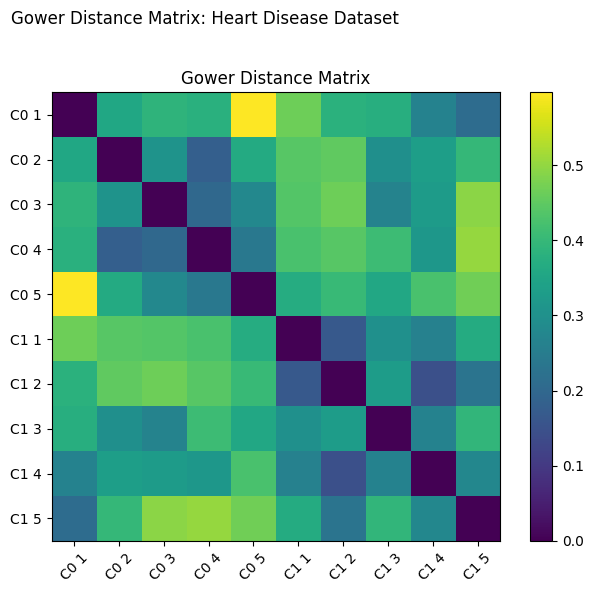

In [57]:
plot_similarity_matrices([gower_dist], y, 
                         titles=["Gower Distance Matrix"],
                         suptitle="Gower Distance Matrix: Heart Disease Dataset",
                         )

- **Group Patterns:** Similar to the categorical distance matrices, we observe higher similarity within healthy patients (H1-H5) and diseased patients (D1-D5), with lower similarity between the two groups
- **Enhanced Separation:** The difference between healthy and diseased patients appears more pronounced than with purely categorical metrics, suggesting that incorporating continuous variables strengthens the discriminative power of the similarity measure

To further explore these relationships, we again project the dissimilarities into two dimensions using PCA and t-SNE.

In [59]:
# Apply PCA to Gower distance matrix
pca = PCA(n_components=2, random_state=42)
gower_pca = pca.fit_transform(gower_dist)

# Apply t-SNE to Gower distance matrix
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
gower_tsne = tsne.fit_transform(gower_dist)


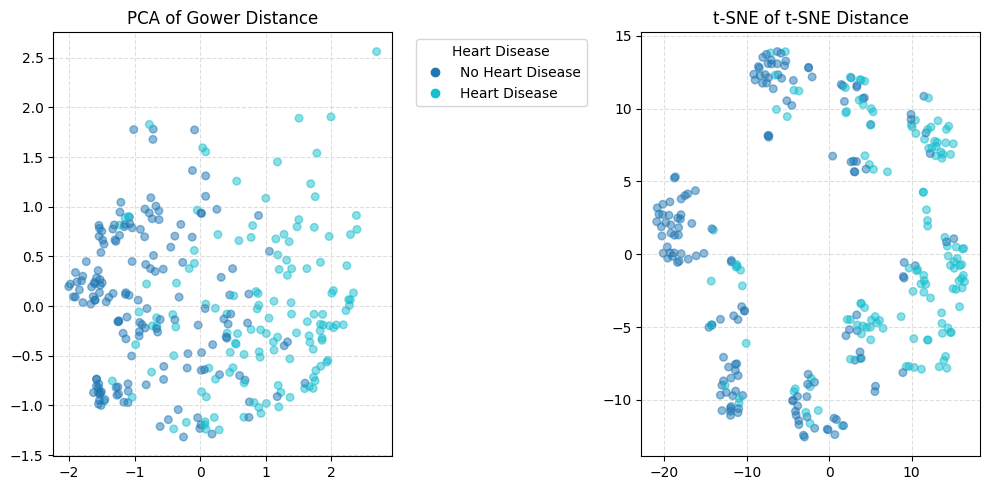

In [60]:
# Plotting
embeddings = [
    (gower_pca, y, "PCA of Gower Distance"),
    (gower_tsne, y, "t-SNE of t-SNE Distance"),
]

plot_projection_grid(embeddings, dataset_name="heart_disease", figsize=(10, 5))

- **Clustering Patterns:** Both PCA and t-SNE reveal clustering of patients, with some separation between healthy (blue) and diseased (orange) groups

- **Multiple Clusters in t-SNE:** The t-SNE visualization shows more distinct clusters than just the binary disease/no disease classification, which seems reasonable given that there could be a range of heart disease types and severity levels

- **Mixed Data Benefits:** By incorporating both continuous and categorical features, Gower distance captures more nuanced patient similarities that reveal subclusters within the broad disease categories

## Similarity Metrics Overview

| Metric              | Data Type         | Key Properties | Best Use Cases |
|---------------------|-------------------|----------------|----------------|
| **Euclidean Distance** | Numeric | Straight-line distance in feature space | Lab results, vitals (similar scales) |
| **Manhattan Distance** | Numeric/Ordinal | Sum of absolute differences | Robust to outliers, ordinal data |
| **Jaccard Distance** | Binary/Categorical | Focuses on shared presences | Comorbidities, symptoms (presence matters) |
| **Hamming Distance** | Binary/Nominal | Counts feature mismatches | Yes/no data, color categories |
| **Simple Matching** | Binary/Nominal | Counts exact matches | Both presence/absence equally important |
| **Gower's Dissimilarity** | Mixed | Handles multiple data types | Clinical records with mixed variables |

**Key Considerations:**
-  **Numeric data:** Euclidean or Manhattan
-  **Categorical data:** Jaccard, Hamming, or Simple Matching
-  **Mixed data:** Gower's

*The right metric ensures your analyses reflect the true structure in biomedical data.*

---